In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# For inline plots in Jupyter
%matplotlib inline
import pandas as pd
import matplotlib as plt
import glob
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from tqdm import tqdm
import codecs
import csv
import openpyxl

In [2]:
data_directory_weather = "/home/paulharford/college/project/project_data/processed/WEATHERED_warnings_2014-2023_cleaned_v3.csv"
data_directory_nas = "/home/paulharford/college/project/project_data/nas/WEATHERED_nas_clean.csv"
data_directory_census = "/home/paulharford/college/project/project_data/processed/WEATHERED_census_pop_age_grp_gender_region.csv"
full_path_nas = os.path.abspath(data_directory_nas)
full_path_weather = os.path.abspath(data_directory_weather)
full_path_census = os.path.abspath(data_directory_census)

In [3]:
df_nas = pd.read_csv(full_path_nas)
df_weather = pd.read_csv(full_path_weather)
df_census = pd.read_csv(full_path_census)

In [4]:
df_weather["Valid From"] = pd.to_datetime(df_weather["Valid From"])
df_weather["date"] = df_weather["Valid From"].dt.date
df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather["Valid To"] = pd.to_datetime(df_weather["Valid To"])


## Create all dates for all years to merge with datasets so we can have days with and without events 

In [5]:
##add full date calandar to the aggregation 
# 1a. Identify all unique regions
regions = df_weather['region'].unique()

# 1b. Identify the full date range
min_date = df_weather['date'].min()
max_date = df_weather['date'].max()

In [6]:
##create all dates for all years to merge with datasets so we can have days with and without events 
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [7]:
##copy full date range for hip and weather data
df_region_date_hip = df_region_date.copy()

In [8]:
df_region_date_weather = df_region_date.copy()

In [9]:
df_region_date_census = df_region_date.copy()

In [10]:
df_region_date.head()

,region,date
0,HSE West and North West,2014-01-02
1,HSE West and North West,2014-01-03
2,HSE West and North West,2014-01-04
3,HSE West and North West,2014-01-05
4,HSE West and North West,2014-01-06


In [11]:
#add column for lag
df_weather['lag_valid_to'] = df_weather['Valid To'] + pd.Timedelta(hours=12)

In [12]:
df_weather.head()

,Issue Time,Valid From,Valid To,Warning Colour,Warning Element,Warning Text,Clare,Cork,Kerry,Limerick,...,Roscommon,Sligo,warning_phenomenon,warning_severity,weather_type,Duration_hours,region,county_count,date,lag_valid_to
0,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Orange,Wind,Becoming stormy this evening and tonight and c...,1,1,1,1,...,1,1,Wind,Orange,Wind warning,21.0,HSE West and North West,6,2014-01-02,2014-01-04 02:00:00+00:00
1,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Orange,Wind,Becoming stormy this evening and tonight and c...,1,1,1,1,...,1,1,Wind,Orange,Wind warning,21.0,HSE South West,2,2014-01-02,2014-01-04 02:00:00+00:00
2,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Orange,Wind,Becoming stormy this evening and tonight and c...,1,1,1,1,...,1,1,Wind,Orange,Wind warning,21.0,HSE Mid West,2,2014-01-02,2014-01-04 02:00:00+00:00
3,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Yellow,Wind,Becoming extremely windy or stormy this evenin...,0,0,0,0,...,0,0,Wind,Yellow,Wind warning,21.0,HSE Dublin and South East,7,2014-01-02,2014-01-04 02:00:00+00:00
4,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Yellow,Wind,Becoming extremely windy or stormy this evenin...,0,0,0,0,...,0,0,Wind,Yellow,Wind warning,21.0,HSE Dublin and North East,5,2014-01-02,2014-01-04 02:00:00+00:00


In [13]:
severity_mapping = {
    'Yellow': 1,
    'Orange': 2,
    'Red': 3
}

df_weather['warning_severity_numeric'] = df_weather['warning_severity'].map(severity_mapping)

In [14]:
def aggregate_weather_data(df_weather):
    """
    Aggregate weather data by Region, date, and weather_type to maintain 
    separate rows for different weather events on the same day.
    
    Args:
        df_weather: DataFrame containing weather data with Region, date, and weather_type columns
        
    Returns:
        Aggregated DataFrame with one row per unique Region-date-weather_type combination
    """
    # First step: Group by Region, date, and weather_type
    # This ensures separate events remain as separate rows
    weather_agg = df_weather.groupby(
        ['region', 'date', 'weather_type', 'warning_severity'], 
        as_index=False
    ).agg({
        'county_count': 'max',
        'warning_severity_numeric': 'max'
    })
    
    # Add the weather flag column (set to 1 if there is any event)
    weather_agg['weather_event'] = 1
    
    return weather_agg

In [15]:
weather_agg = aggregate_weather_data(df_weather)

In [16]:
weather_agg.head()

,region,date,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event
0,HSE Dublin and Midlands,2014-01-02,Wind warning,Yellow,7,1.0,1
1,HSE Dublin and Midlands,2014-01-03,Wind warning,Yellow,7,1.0,1
2,HSE Dublin and Midlands,2014-01-04,Snow_Ice warning,Yellow,7,1.0,1
3,HSE Dublin and Midlands,2014-01-05,Wind warning,Yellow,7,1.0,1
4,HSE Dublin and Midlands,2014-01-06,Wind warning,Orange,7,2.0,1


In [17]:
df_weather_final = pd.merge(
    df_region_date_weather,          # all region-date combos
    weather_agg,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)

In [18]:
df_weather_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23124 entries, 0 to 23123
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region                    23124 non-null  object        
 1   date                      23124 non-null  datetime64[ns]
 2   weather_type              5189 non-null   object        
 3   warning_severity          5189 non-null   object        
 4   county_count              5189 non-null   float64       
 5   warning_severity_numeric  5135 non-null   float64       
 6   weather_event             5189 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 1.2+ MB


In [ ]:
##after joing wetaher data to full fate range there and NaN values, whixh is expected as not all days have weather events
df_weather_final['warning_severity_numeric'] = df_weather_final['warning_severity_numeric'].fillna(0)

In [ ]:
df_weather_final['weather_event'] = df_weather_final['weather_event'].fillna(0)

In [ ]:
df_weather_final['county_count'] = df_weather_final['county_count'].fillna(0)

In [ ]:
df_weather_final['weather_type'] = df_weather_final['weather_type'].fillna('no_weather_type')

In [ ]:
df_weather_final['warning_severity'] = df_weather_final['warning_severity'].fillna('no_severity')

In [19]:
## So the final weather warning_phenomenon has per region the severity, if there was a wether event or not, the numer of counties the evnet was in and the weather tyep (wind/rain etc)
df_weather_final.head(10)

,region,date,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event
0,HSE West and North West,2014-01-02,Wind warning,Orange,6.0,2.0,1.0
1,HSE West and North West,2014-01-03,Wind warning,Yellow,6.0,1.0,1.0
2,HSE West and North West,2014-01-04,Snow_Ice warning,Yellow,6.0,1.0,1.0
3,HSE West and North West,2014-01-05,Wind warning,Orange,3.0,2.0,1.0
4,HSE West and North West,2014-01-05,Wind warning,Yellow,6.0,1.0,1.0
5,HSE West and North West,2014-01-06,Wind warning,Orange,6.0,2.0,1.0
6,HSE West and North West,2014-01-06,Wind warning,Yellow,6.0,1.0,1.0
7,HSE West and North West,2014-01-07,NaN,NaN,NaN,NaN,NaN
8,HSE West and North West,2014-01-08,NaN,NaN,NaN,NaN,NaN
9,HSE West and North West,2014-01-09,NaN,NaN,NaN,NaN,NaN


In [20]:
df_weather_filtered = df_weather_final[
    (df_weather_final['date'] >= '2016-01-01') & 
    (df_weather_final['date'] <= '2023-12-31').copy()
]

## NAS Data
#### get NAS data ready to merge with weather data

In [21]:
# convert to a pandas datetime if you prefer consistency
df_nas["date"] = pd.to_datetime(df_nas["date"])

In [23]:
df_nas.head()

,date,Time of Day,PickupTown,DespatchCode,DespCodeDescription,Hospital Attended,region
0,2016-01-01,Night,DUNGLOE,17B01P,Falls - Possibly Dangerous body Area - Public ...,LETTERKENNY GENERAL HOSPITAL,HSE West and North West
1,2016-01-01,Night,BEAUMONT DUBLIN 9,17B01G,Falls - Possibly Dangerous body Area - On the ...,BEAUMONT HOSPITAL,HSE Dublin and North East
2,2016-01-01,Night,DROGHEDA,17B01,Falls - Possibly Dangerous body Area -,LOURDES HOSPITAL DROGHEDA,HSE Dublin and North East
3,2016-01-01,Night,BORRISOKANE,17B01P,Falls - Possibly Dangerous body Area - Public ...,PORTIUNCULA GENERAL HOSPITAL,HSE West and North West
4,2016-01-01,Night,WEXFORD,17B01G,Falls - Possibly Dangerous body Area - On the ...,Unknown,Unknown


In [24]:
df_nas_filtered = df_nas[
    (df_nas['date'] >= '2016-01-01') & 
    (df_nas['date'] <= '2023-12-31').copy()
]

In [25]:
df_nas_season = df_nas_filtered.copy()

In [26]:
def month_to_season(month):
    # Convert month to an integer if it isn't already.
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'unknown'




In [27]:
nan_counts = df_nas_filtered.isna().sum()
print(nan_counts)

date                    0
Time of Day             0
PickupTown             13
DespatchCode            0
DespCodeDescription     0
Hospital Attended       0
region                  0
dtype: int64


In [29]:
df_nas_filtered['PickupTown'] = df_nas_filtered['PickupTown'].fillna('no_town_specified')

## merging

In [31]:
nas_agg = (
    df_nas_filtered
    .groupby(['region', 'date'])
    .agg(hip_fracture_callout=('date', 'count'))
    .reset_index()
)


In [32]:
nas_agg.head()


,region,date,hip_fracture_callout
0,HSE Dublin and Midlands,2016-01-01,8
1,HSE Dublin and Midlands,2016-01-02,5
2,HSE Dublin and Midlands,2016-01-03,2
3,HSE Dublin and Midlands,2016-01-04,5
4,HSE Dublin and Midlands,2016-01-05,2


In [33]:
##add full date calandar to the aggregation 
# 1a. Identify all unique regions
regions = nas_agg['region'].unique()

# 1b. Identify the full date range
min_date = nas_agg['date'].min()
max_date = nas_agg['date'].max()

In [34]:
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [35]:
df_region_date.head(15)

,region,date
0,HSE Dublin and Midlands,2016-01-01
1,HSE Dublin and Midlands,2016-01-02
2,HSE Dublin and Midlands,2016-01-03
3,HSE Dublin and Midlands,2016-01-04
4,HSE Dublin and Midlands,2016-01-05
5,HSE Dublin and Midlands,2016-01-06
6,HSE Dublin and Midlands,2016-01-07
7,HSE Dublin and Midlands,2016-01-08
8,HSE Dublin and Midlands,2016-01-09
9,HSE Dublin and Midlands,2016-01-10


In [36]:
df_nas_final = pd.merge(
    df_region_date,          # all region-date combos
    nas_agg,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)

In [37]:
df_nas_final['month'] = df_nas_final['date'].dt.month

In [38]:
df_nas_final.head(10)

,region,date,hip_fracture_callout,month
0,HSE Dublin and Midlands,2016-01-01,8.0,1
1,HSE Dublin and Midlands,2016-01-02,5.0,1
2,HSE Dublin and Midlands,2016-01-03,2.0,1
3,HSE Dublin and Midlands,2016-01-04,5.0,1
4,HSE Dublin and Midlands,2016-01-05,2.0,1
5,HSE Dublin and Midlands,2016-01-06,6.0,1
6,HSE Dublin and Midlands,2016-01-07,4.0,1
7,HSE Dublin and Midlands,2016-01-08,8.0,1
8,HSE Dublin and Midlands,2016-01-09,4.0,1
9,HSE Dublin and Midlands,2016-01-10,3.0,1


In [39]:
df_nas_final['year'] = df_nas_final['date'].dt.year

In [40]:
merged = pd.merge(df_nas_final, df_weather_final , on=['region', 'date'], how='left')



In [43]:
nan_counts = merged.isna().sum()
print(nan_counts)

region                      0
date                        0
hip_fracture_callout        0
month                       0
year                        0
weather_type                0
warning_severity            0
county_count                0
warning_severity_numeric    0
weather_event               0
dtype: int64


In [42]:
# Fill missing weather_flag values with 0 (indicating no adverse weather event)
merged['warning_severity_numeric'] = merged['warning_severity_numeric'].fillna(0)
merged['county_count'] = merged['county_count'].fillna(0)
merged['weather_event'] = merged['weather_event'].fillna(0)
merged['hip_fracture_callout'] = merged['hip_fracture_callout'].fillna(0)
merged['weather_type'] = merged['weather_type'].fillna('no_weather_type')
merged['warning_severity'] = merged['warning_severity'].fillna('no_weather_severity')



merged['hip_adv_event'] = ((merged['hip_fracture_count'] > 0) & (merged['weather_flag'] == 1)).astype(int)


In [44]:
merged.head(10)

,region,date,hip_fracture_callout,month,year,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event
0,HSE Dublin and Midlands,2016-01-01,8.0,1,2016,Rainfall warning,Yellow,2.0,1.0,1.0
1,HSE Dublin and Midlands,2016-01-02,5.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0
2,HSE Dublin and Midlands,2016-01-03,2.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0
3,HSE Dublin and Midlands,2016-01-04,5.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0
4,HSE Dublin and Midlands,2016-01-05,2.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0
5,HSE Dublin and Midlands,2016-01-06,6.0,1,2016,Rainfall warning,Yellow,7.0,1.0,1.0
6,HSE Dublin and Midlands,2016-01-07,4.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0
7,HSE Dublin and Midlands,2016-01-08,8.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0
8,HSE Dublin and Midlands,2016-01-09,4.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0
9,HSE Dublin and Midlands,2016-01-10,3.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0


In [45]:
merged['year'] = merged['date'].dt.year

In [46]:
unique_regions_census = df_census['region'].unique()
print("Unique regions in df_census:", unique_regions_census)

Unique regions in df_census: ['HSE Dublin and Midlands' 'HSE Dublin and North East'
 'HSE Dublin and South East' 'HSE Midwest' 'HSE South West'
 'HSE West and North West']


In [47]:
unique_regions_census = merged['region'].unique()
print("Unique regions in df_census:", unique_regions_census)

Unique regions in df_census: ['HSE Dublin and Midlands' 'HSE Dublin and North East'
 'HSE Dublin and South East' 'HSE Mid West' 'HSE South East'
 'HSE West and North West' 'Hospital Unknown' 'Unknown']


In [48]:
##naming corrections 
df_census['region'] = df_census['region'].replace({'HSE Midwest': 'HSE Mid West'})

In [49]:
merged['region'] = merged['region'].replace({'HSE South East': 'HSE South West'})

In [50]:
df_with_pop = pd.merge(
    merged,     # your merged daily data (weather + hip fractures)
    df_census,     # population per region-year
    how='left', # keep all rows from merged even if no match found
    on=['region','year']
)

In [51]:
df_with_pop.head(15)

,region,date,hip_fracture_callout,month,year,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event,population
0,HSE Dublin and Midlands,2016-01-01,8.0,1,2016,Rainfall warning,Yellow,2.0,1.0,1.0,327547.0
1,HSE Dublin and Midlands,2016-01-02,5.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0
2,HSE Dublin and Midlands,2016-01-03,2.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0
3,HSE Dublin and Midlands,2016-01-04,5.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0
4,HSE Dublin and Midlands,2016-01-05,2.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0
5,HSE Dublin and Midlands,2016-01-06,6.0,1,2016,Rainfall warning,Yellow,7.0,1.0,1.0,327547.0
6,HSE Dublin and Midlands,2016-01-07,4.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0
7,HSE Dublin and Midlands,2016-01-08,8.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0
8,HSE Dublin and Midlands,2016-01-09,4.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0
9,HSE Dublin and Midlands,2016-01-10,3.0,1,2016,no_weather_type,no_weather_severity,0.0,0.0,0.0,327547.0


In [52]:
# Count entries with either 'Hospital Unknown' or 'Unknown'
count = df_with_pop[df_with_pop['region'].isin(['Hospital Unknown', 'Unknown'])].shape[0]
print("Count of entries with 'Hospital Unknown' or 'Unknown':", count)



Count of entries with 'Hospital Unknown' or 'Unknown': 5844


In [53]:
# Filter out rows where region is 'Hospital Unknown' or 'Unknown'
df_with_pop = df_with_pop[~df_with_pop['region'].isin(['Hospital Unknown', 'Unknown'])]

# Verify by checking unique values
print(df_with_pop['region'].unique())


['HSE Dublin and Midlands' 'HSE Dublin and North East'
 'HSE Dublin and South East' 'HSE Mid West' 'HSE South West'
 'HSE West and North West']


In [54]:
df_with_pop['log_population'] = np.log(df_with_pop['population'])

In [55]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [57]:
import statsmodels.formula.api as smf

formula = """
hip_fracture_callout ~ 
    region + 
    weather_event + 
    warning_severity_numeric + 
    C(weather_type) + 
    region:weather_event + 
    region:warning_severity_numeric + 
    region:C(weather_type) + 
    weather_event:warning_severity_numeric + 
    region:weather_event:warning_severity_numeric
"""

# Fit the Poisson regression model (without an offset for this example)
poisson_model = smf.glm(formula=formula, data=df_with_pop, family=sm.families.Poisson(),offset=df_with_pop['log_population']).fit()


# Print the summary of the model
print("Poisson Regression Results:")
print(poisson_model.summary())

# Optionally, check for overdispersion:
print("Residual Deviance:", poisson_model.deviance)
print("Degrees of Freedom:", poisson_model.df_resid)

Poisson Regression Results:
                  Generalized Linear Model Regression Results                   
Dep. Variable:     hip_fracture_callout   No. Observations:                18314
Model:                              GLM   Df Residuals:                    18253
Model Family:                   Poisson   Df Model:                           60
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -46612.
Date:                  Sat, 01 Mar 2025   Deviance:                       25498.
Time:                          15:31:18   Pearson chi2:                 2.49e+04
No. Iterations:                     100   Pseudo R-squ. (CS):             0.3802
Covariance Type:              nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [59]:
##becuase we can see some over dispersion i'm trying a quasi-poisson and a negative binomial 
formula = """
hip_fracture_callout ~ 
    region + 
    weather_event + 
    warning_severity_numeric + 
    C(weather_type) + 
    region:weather_event + 
    region:warning_severity_numeric + 
    region:C(weather_type) + 
    weather_event:warning_severity_numeric + 
    region:weather_event:warning_severity_numeric
"""
poisson_model = smf.glm(
    formula=formula, 
    data=df_with_pop, 
    family=sm.families.Poisson(), 
    offset=np.log(df_with_pop['population'])
)

# First fit the regular Poisson model
poisson_results = poisson_model.fit()

# Calculate the dispersion parameter
dispersion = poisson_results.deviance / poisson_results.df_resid
print(f"Dispersion parameter: {dispersion:.4f}")

# Now fit the quasi-Poisson model by specifying the scale parameter
quasi_poisson_results = poisson_model.fit(scale=dispersion)

# Print the summary of the quasi-Poisson model
print(quasi_poisson_results.summary())

Dispersion parameter: 1.3969
                  Generalized Linear Model Regression Results                   
Dep. Variable:     hip_fracture_callout   No. Observations:                18314
Model:                              GLM   Df Residuals:                    18253
Model Family:                   Poisson   Df Model:                           60
Link Function:                      Log   Scale:                          1.3969
Method:                            IRLS   Log-Likelihood:                -33368.
Date:                  Sat, 01 Mar 2025   Deviance:                       25498.
Time:                          15:32:19   Pearson chi2:                 2.49e+04
No. Iterations:                     100   Pseudo R-squ. (CS):             0.2899
Covariance Type:              nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------

In [60]:
def calculate_standardized_rates_simple(model, df, regions):
    """
    A simple, reliable approach to calculate standardized rates by region
    
    Parameters:
    -----------
    model : statsmodels results object
        Fitted model from statsmodels
    df : pandas DataFrame
        Your original dataset
    regions : list
        List of regions to calculate rates for
    
    Returns:
    --------
    pandas DataFrame
        Standardized rates by region
    """
    # Create empty list to store results
    results = []
    
    # Iterate through each region
    for region in regions:
        # Find rows for this region
        region_data = df[df['region'] == region]
        
        if len(region_data) == 0:
            print(f"No data found for region: {region}")
            continue
        
        # Make a copy of the first row for this region
        template_row = region_data.iloc[0:1].copy()
        
        # Set standard conditions
        template_row['population'] = 100000
        template_row['log_population'] = np.log(100000)
        template_row['warning_severity_numeric'] = 0  # No warning
        template_row['weather_event'] = 0  # No weather event
        
        # Use the most common weather_type in the dataset
        most_common_type = df['weather_type'].value_counts().index[0]
        template_row['weather_type'] = most_common_type
        
        # Try to predict
        try:
            predicted_count = model.predict(template_row).iloc[0]
            
            # Add to results
            results.append({
                'Region': region,
                'Rate per 100,000': predicted_count,
                'Weather Type': most_common_type
            })
            
            print(f"Successfully predicted for {region}: {predicted_count}")
            
        except Exception as e:
            print(f"Error predicting for {region}:")
            print(f"  {str(e)}")
            
            # Try with the original values from the template row
            try:
                original_template = region_data.iloc[0:1].copy()
                original_template['population'] = 100000
                original_template['log_population'] = np.log(100000)
                
                predicted_count = model.predict(original_template).iloc[0]
                results.append({
                    'Region': region,
                    'Rate per 100,000': predicted_count,
                    'Weather Type': original_template['weather_type'].iloc[0],
                    'Used Original Values': True
                })
                
                print(f"  Success using original values: {predicted_count}")
                
            except Exception as e2:
                print(f"  Second attempt also failed: {str(e2)}")
                results.append({
                    'Region': region,
                    'Rate per 100,000': float('nan'),
                    'Error': str(e)
                })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by rate (descending)
    if not results_df.empty and 'Rate per 100,000' in results_df.columns:
        results_df = results_df.sort_values('Rate per 100,000', ascending=False)
    
    return results_df

In [61]:
def calculate_warning_impact(model, df, regions, warning_level=3):
    """
    Calculate the impact of weather warnings on hip fracture rates
    
    This function uses the model fitted with offset as a parameter and
    converts predictions to rates per 100,000 population by applying
    a scaling factor of 100,000.
    
    Parameters:
    -----------
    model : statsmodels results object
        Fitted model from statsmodels
    df : pandas DataFrame
        Your original dataset
    regions : list
        List of regions to calculate rates for
    warning_level : int, default 3
        Level of warning to analyze (1=Yellow, 2=Orange, 3=Red)
    
    Returns:
    --------
    pandas DataFrame
        Impact of specified warning level by region
    """
    # Validate warning level
    if warning_level not in [1, 2, 3]:
        print(f"Warning: Invalid warning level {warning_level}. Using level 3 (Red) instead.")
        warning_level = 3
    
    # Map warning levels to their names for display
    warning_names = {1: "Yellow", 2: "Orange", 3: "Red"}
    warning_name = warning_names[warning_level]
    
    # Results containers
    baseline_results = []
    warning_results = []
    
    # Most common weather type
    most_common_type = df['weather_type'].value_counts().index[0]
    print(f"Using {most_common_type} as the weather type")
    
    # Process each region
    for region in regions:
        # Find rows for this region
        region_data = df[df['region'] == region]
        
        if len(region_data) == 0:
            print(f"No data found for region: {region}")
            continue
        
        # Create baseline scenario (no warning)
        baseline_row = region_data.iloc[0:1].copy()
        baseline_row['population'] = 100000
        baseline_row['log_population'] = np.log(100000)
        baseline_row['warning_severity_numeric'] = 0
        baseline_row['weather_event'] = 1  # During weather event
        baseline_row['weather_type'] = most_common_type
        
        # Create warning scenario with the specified level
        warning_row = baseline_row.copy()
        warning_row['warning_severity_numeric'] = warning_level
        
        # Make predictions and convert to rates per 100,000
        try:
            baseline_pred = model.predict(baseline_row).iloc[0] * 100000
            warning_pred = model.predict(warning_row).iloc[0] * 100000
            
            # Store results
            baseline_results.append({
                'Region': region,
                'Rate': baseline_pred
            })
            
            warning_results.append({
                'Region': region,
                'Rate': warning_pred
            })
            
            print(f"Region: {region}, Baseline: {baseline_pred:.4f}, {warning_name} Warning: {warning_pred:.4f}")
            
        except Exception as e:
            print(f"Error calculating for {region}: {str(e)}")
    
    # Combine results
    if baseline_results and warning_results:
        baseline_df = pd.DataFrame(baseline_results)
        warning_df = pd.DataFrame(warning_results)
        
        # Merge the dataframes
        combined = pd.merge(
            baseline_df,
            warning_df,
            on='Region',
            suffixes=('_baseline', f'_{warning_name.lower()}_warning')
        )
        
        # Calculate changes
        combined['Absolute Increase'] = combined[f'Rate_{warning_name.lower()}_warning'] - combined['Rate_baseline']
        combined['Percentage Increase'] = (combined['Absolute Increase'] / combined['Rate_baseline']) * 100
        
        # Rename columns for clarity
        combined = combined.rename(columns={
            'Rate_baseline': 'Rate per 100,000_baseline',
            f'Rate_{warning_name.lower()}_warning': f'Rate per 100,000_{warning_name.lower()}_warning'
        })
        
        # Format numeric columns to be more readable
        for col in combined.columns:
            if col != 'Region' and combined[col].dtype in ['float64', 'float32']:
                combined[col] = combined[col].round(4)
        
        # Sort by baseline rate
        combined = combined.sort_values('Rate per 100,000_baseline', ascending=False)
        
        return combined
    else:
        print("No valid predictions to compare")
        return pd.DataFrame()

In [63]:
# Extract all unique regions from your dataset
all_regions = df_with_pop['region'].unique().tolist()

# Print the regions to verify
print("HSE Regions included in analysis:")
for region in all_regions:
    print(f"- {region}")

HSE Regions included in analysis:
- HSE Dublin and Midlands
- HSE Dublin and North East
- HSE Dublin and South East
- HSE Mid West
- HSE South West
- HSE West and North West


In [64]:
# Calculate impact of yellow warnings (level 1)
yellow_impact = calculate_warning_impact(quasi_poisson_results, df_with_pop, all_regions, warning_level=1)
yellow_impact


Using no_weather_type as the weather type
Region: HSE Dublin and Midlands, Baseline: 0.0449, Yellow Warning: 0.0483
Region: HSE Dublin and North East, Baseline: 0.0500, Yellow Warning: 0.0486
Region: HSE Dublin and South East, Baseline: 0.1086, Yellow Warning: 0.1097
Region: HSE Mid West, Baseline: 0.0696, Yellow Warning: 0.0738
Region: HSE South West, Baseline: 0.0686, Yellow Warning: 0.0738
Region: HSE West and North West, Baseline: 0.1056, Yellow Warning: 0.1028


,Region,"Rate per 100,000_baseline","Rate per 100,000_yellow_warning",Absolute Increase,Percentage Increase
2,HSE Dublin and South East,0.1086,0.1097,0.0011,1.0451
5,HSE West and North West,0.1056,0.1028,-0.0028,-2.6584
3,HSE Mid West,0.0696,0.0738,0.0042,5.9871
4,HSE South West,0.0686,0.0738,0.0052,7.5812
1,HSE Dublin and North East,0.0500,0.0486,-0.0014,-2.8003
0,HSE Dublin and Midlands,0.0449,0.0483,0.0034,7.5812


In [65]:
# Calculate impact of orange warnings (level 2)
orange_impact = calculate_warning_impact(quasi_poisson_results, df_with_pop, all_regions, warning_level=2)
orange_impact


Using no_weather_type as the weather type
Region: HSE Dublin and Midlands, Baseline: 0.0449, Orange Warning: 0.0520
Region: HSE Dublin and North East, Baseline: 0.0500, Orange Warning: 0.0472
Region: HSE Dublin and South East, Baseline: 0.1086, Orange Warning: 0.1109
Region: HSE Mid West, Baseline: 0.0696, Orange Warning: 0.0782
Region: HSE South West, Baseline: 0.0686, Orange Warning: 0.0794
Region: HSE West and North West, Baseline: 0.1056, Orange Warning: 0.1000


,Region,"Rate per 100,000_baseline","Rate per 100,000_orange_warning",Absolute Increase,Percentage Increase
2,HSE Dublin and South East,0.1086,0.1109,0.0023,2.1011
5,HSE West and North West,0.1056,0.1000,-0.0055,-5.2462
3,HSE Mid West,0.0696,0.0782,0.0086,12.3327
4,HSE South West,0.0686,0.0794,0.0108,15.7371
1,HSE Dublin and North East,0.0500,0.0472,-0.0028,-5.5223
0,HSE Dublin and Midlands,0.0449,0.0520,0.0071,15.7371


In [66]:
# Calculate impact of red warnings (level 3)
red_impact = calculate_warning_impact(quasi_poisson_results, df_with_pop, all_regions, warning_level=3)
red_impact

Using no_weather_type as the weather type
Region: HSE Dublin and Midlands, Baseline: 0.0449, Red Warning: 0.0559
Region: HSE Dublin and North East, Baseline: 0.0500, Red Warning: 0.0459
Region: HSE Dublin and South East, Baseline: 0.1086, Red Warning: 0.1120
Region: HSE Mid West, Baseline: 0.0696, Red Warning: 0.0829
Region: HSE South West, Baseline: 0.0686, Red Warning: 0.0854
Region: HSE West and North West, Baseline: 0.1056, Red Warning: 0.0974


,Region,"Rate per 100,000_baseline","Rate per 100,000_red_warning",Absolute Increase,Percentage Increase
2,HSE Dublin and South East,0.1086,0.1120,0.0034,3.1681
5,HSE West and North West,0.1056,0.0974,-0.0082,-7.7651
3,HSE Mid West,0.0696,0.0829,0.0133,19.0581
4,HSE South West,0.0686,0.0854,0.0168,24.5113
1,HSE Dublin and North East,0.0500,0.0459,-0.0041,-8.1680
0,HSE Dublin and Midlands,0.0449,0.0559,0.0110,24.5113


In [67]:
def generate_combined_rates_table(model, df, regions):
    """
    Generate a combined table of hip fracture rates for different warning levels
    
    This function calculates rates for no warning, yellow, orange, and red warnings,
    and combines them into a single table for comparison and visualization.
    
    Parameters:
    -----------
    model : statsmodels results object
        Fitted model from statsmodels
    df : pandas DataFrame
        Your original dataset
    regions : list
        List of regions to calculate rates for
        
    Returns:
    --------
    tuple
        (combined_rates_df, plot_data_df) - tables for display and plotting
    """
    # Create a function to extract just the baseline rates from each calculation
    def get_rates_for_level(warning_level):
        results = calculate_warning_impact(model, df, regions, warning_level=warning_level)
        
        if warning_level == 0:
            # For baseline (no warning)
            return pd.DataFrame({
                'Region': results['Region'],
                'No Warning': results['Rate per 100,000_baseline']
            })
        else:
            # For warning levels
            warning_name = {1: 'Yellow', 2: 'Orange', 3: 'Red'}[warning_level]
            return pd.DataFrame({
                'Region': results['Region'],
                f'{warning_name} Warning': results[f'Rate per 100,000_{warning_name.lower()}_warning']
            })
    
    # Calculate rates for each warning level
    baseline_rates = get_rates_for_level(0)
    yellow_rates = get_rates_for_level(1)
    orange_rates = get_rates_for_level(2)
    red_rates = get_rates_for_level(3)
    
    # Merge the results
    combined_rates = baseline_rates
    for df_to_merge in [yellow_rates, orange_rates, red_rates]:
        combined_rates = pd.merge(combined_rates, df_to_merge, on='Region')
    
    # Sort by baseline rate
    combined_rates = combined_rates.sort_values('No Warning', ascending=False)
    
    # Create a long-format version for plotting
    plot_data = combined_rates.melt(
        id_vars=['Region'],
        value_vars=['No Warning', 'Yellow Warning', 'Orange Warning', 'Red Warning'],
        var_name='Warning Level',
        value_name='Rate per 100,000'
    )
    
    return combined_rates, plot_data

Using no_weather_type as the weather type
Region: HSE Dublin and Midlands, Baseline: 0.0449, Red Warning: 0.0559
Region: HSE Dublin and North East, Baseline: 0.0500, Red Warning: 0.0459
Region: HSE Dublin and South East, Baseline: 0.1086, Red Warning: 0.1120
Region: HSE Mid West, Baseline: 0.0696, Red Warning: 0.0829
Region: HSE South West, Baseline: 0.0686, Red Warning: 0.0854
Region: HSE West and North West, Baseline: 0.1056, Red Warning: 0.0974
Using no_weather_type as the weather type
Region: HSE Dublin and Midlands, Baseline: 0.0449, Yellow Warning: 0.0483
Region: HSE Dublin and North East, Baseline: 0.0500, Yellow Warning: 0.0486
Region: HSE Dublin and South East, Baseline: 0.1086, Yellow Warning: 0.1097
Region: HSE Mid West, Baseline: 0.0696, Yellow Warning: 0.0738
Region: HSE South West, Baseline: 0.0686, Yellow Warning: 0.0738
Region: HSE West and North West, Baseline: 0.1056, Yellow Warning: 0.1028
Using no_weather_type as the weather type
Region: HSE Dublin and Midlands, Bas

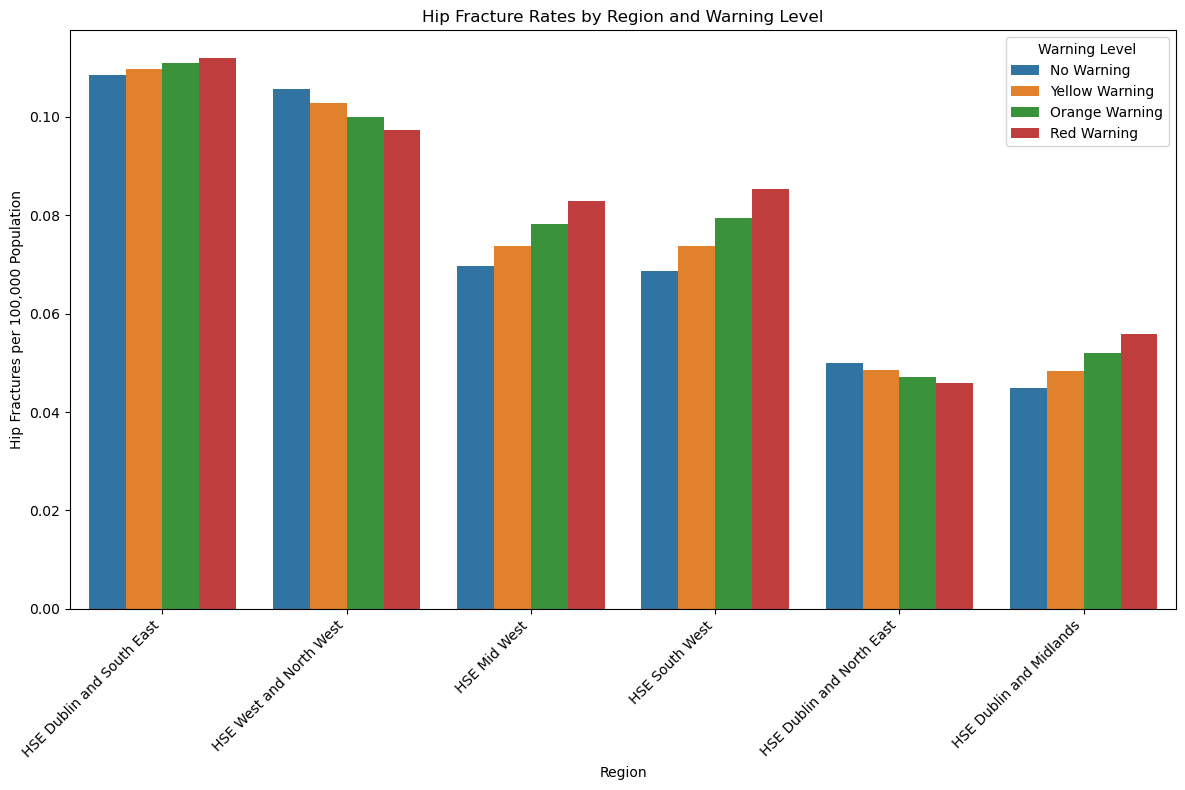

In [69]:
# Generate the combined rates table and plotting data
combined_rates, plot_data = generate_combined_rates_table(quasi_poisson_results, df_with_pop, all_regions)

# Display the combined rates table
print("Combined Hip Fracture Rates by Region and Warning Level (per 100,000 population):")
print("==============================================================================")
print(combined_rates)

# Now you can use plot_data directly for visualization
# For example:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
g = sns.barplot(x='Region', y='Rate per 100,000', hue='Warning Level', data=plot_data)
plt.title('Hip Fracture Rates by Region and Warning Level')
plt.xlabel('Region')
plt.ylabel('Hip Fractures per 100,000 Population')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Warning Level')
plt.savefig('hip_fracture_rates_by_warning.png')
plt.show()